In [1]:
import os
import sys
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/Users/raul.sanchez/data_scientia/rulo_mota_omath


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import train_test_split

from src import config
from src.features import X_features
from src.features import banxico_mun_income_remittances

In [3]:
path = os.path.join(
    config.PRJ_DIR,
    'data/processed/X.csv')

data = pd.read_csv(path)
data.set_index('id', inplace=True)

remittances = banxico_mun_income_remittances.get()

In [4]:
X_2019 = data[data['year'] == 2019].drop(
    ['year', 'mun', 'year.1','year.2', 'mun.1', 'mun.2'], 
    axis=1).apply(lambda x: np.log1p(x))

valid_ids_2019 = list(set(remittances.index).intersection(X_2019.index))

X_2019 = X_2019.loc[valid_ids_2019]
y_2019 = remittances.loc[valid_ids_2019]['Remittance Amount Million USD log1p']

divide by zero encountered in log1p
invalid value encountered in log1p


In [5]:
X_2020 = data[data['year'] == 2020].drop(
    ['year', 'mun', 'year.1','year.2', 'mun.1', 'mun.2'], 
    axis=1).apply(lambda x: np.log1p(x))

valid_ids_2020 = list(set(remittances.index).intersection(X_2020.index))

X_2020 = X_2020.loc[valid_ids_2020]
y_2020 = remittances.loc[valid_ids_2020]['Remittance Amount Million USD log1p']

divide by zero encountered in log1p
invalid value encountered in log1p


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_2019, y_2019, 
    train_size=.8,
    random_state=1)

eval_set = [
    (X_2020, y_2020),
    (X_train, y_train),
    (X_test, y_test)]

model = XGBRegressor(
    learning_rate=0.01, 
    max_depth=8, 
    n_estimators=1000)

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    early_stopping_rounds=10,
    verbose=True)

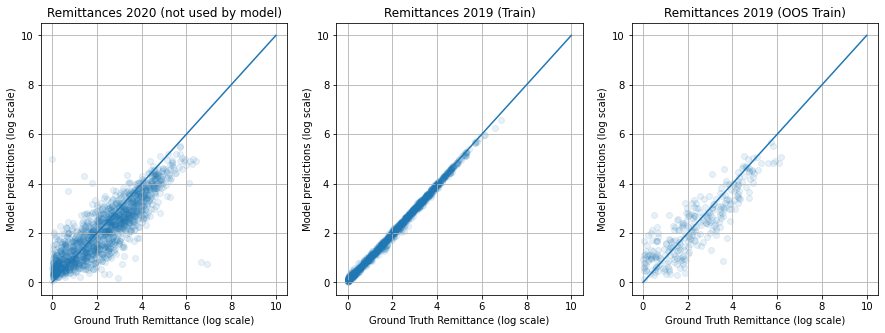

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
eval_set_name = ['Remittances 2020 (not used by model)', 'Remittances 2019 (Train)', 'Remittances 2019 (OOS Train)']
for it, (X, y_true) in enumerate(eval_set):
    y_pred = model.predict(X)
    
    ax[it].scatter(
        y_true.values,
        y_pred,
        alpha=.1)
    ax[it].set_title('%s' % eval_set_name[it])
    
    ax[it].plot([0, 10], [0, 10])
    ax[it].set_xlabel('Ground Truth Remittance (log scale)')
    ax[it].set_ylabel('Model predictions (log scale)')
    
    ax[it].grid()

invalid value encountered in subtract
invalid value encountered in true_divide


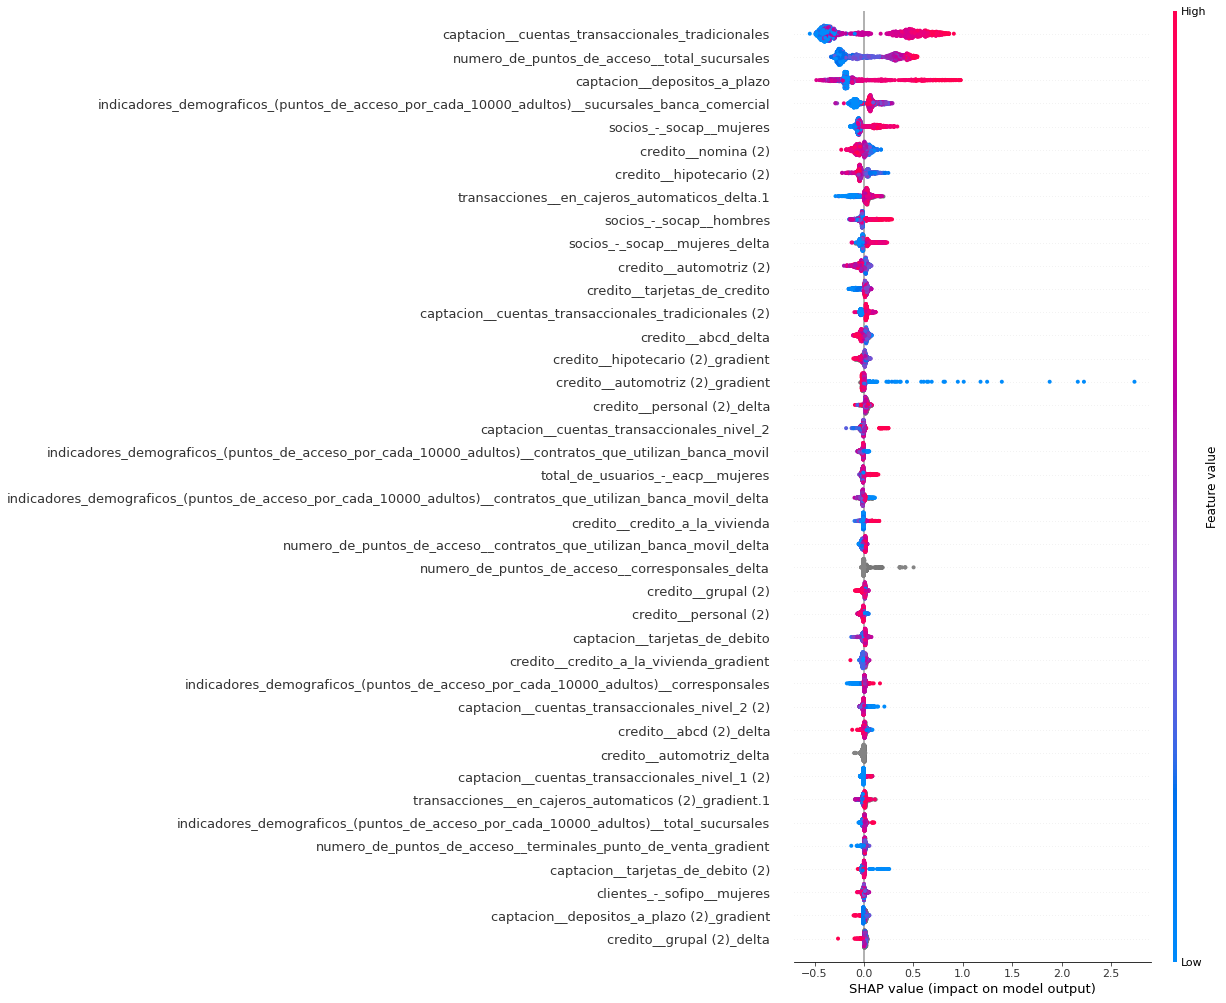

In [24]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(
    X_2020)

features_shap_values = pd.DataFrame(
    shap_values,
    columns=X_2020.columns)

shap.summary_plot(
    shap_values, 
    X_2020, 
    max_display=40)

In [ ]:
shap.TreeExplainer(model).shap_interaction_values(X)